<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Document-Distance" data-toc-modified-id="Document-Distance-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Document Distance</a></span><ul class="toc-item"><li><span><a href="#Text-Re-Use" data-toc-modified-id="Text-Re-Use-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Text Re-Use</a></span></li><li><span><a href="#Cosine-Similarity" data-toc-modified-id="Cosine-Similarity-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Cosine Similarity</a></span></li><li><span><a href="#Jensen-Shannon-Divergence" data-toc-modified-id="Jensen-Shannon-Divergence-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Jensen-Shannon Divergence</a></span></li></ul></li><li><span><a href="#Clustering" data-toc-modified-id="Clustering-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Clustering</a></span><ul class="toc-item"><li><span><a href="#K-means-clustering" data-toc-modified-id="K-means-clustering-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>K-means clustering</a></span><ul class="toc-item"><li><span><a href="#Silhouette-Score" data-toc-modified-id="Silhouette-Score-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Silhouette Score</a></span></li></ul></li><li><span><a href="#K-Medoids" data-toc-modified-id="K-Medoids-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>K-Medoids</a></span></li><li><span><a href="#DBSCAN" data-toc-modified-id="DBSCAN-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>DBSCAN</a></span><ul class="toc-item"><li><span><a href="#Hierarchical-DBSCAN" data-toc-modified-id="Hierarchical-DBSCAN-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>Hierarchical DBSCAN</a></span></li></ul></li><li><span><a href="#Hierarchical-Clustering" data-toc-modified-id="Hierarchical-Clustering-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Hierarchical Clustering</a></span></li><li><span><a href="#Principal-Component-Analysis" data-toc-modified-id="Principal-Component-Analysis-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Principal Component Analysis</a></span></li></ul></li><li><span><a href="#Latent-Dirichlet-Allocation" data-toc-modified-id="Latent-Dirichlet-Allocation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Latent Dirichlet Allocation</a></span><ul class="toc-item"><li><span><a href="#Singular-Value-Decomposition-(SVD)" data-toc-modified-id="Singular-Value-Decomposition-(SVD)-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Singular Value Decomposition (SVD)</a></span></li><li><span><a href="#Non-negative-Matrix-Factorization-(NMF)" data-toc-modified-id="Non-negative-Matrix-Factorization-(NMF)-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Non-negative Matrix Factorization (NMF)</a></span></li><li><span><a href="#Author-Topic-Model" data-toc-modified-id="Author-Topic-Model-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Author Topic Model</a></span></li></ul></li></ul></div>

Natural Language Processing for Law and Social Science<br>
Elliott Ash, ETH Zurich

In [1]:
# set random seed
import numpy as np
np.random.seed(4)

In [2]:
# If you are using Google Colab, here's the code to load sc_cases_cleaned.pkl from local. 
from google.colab import files
uploaded_1 = files.upload()
uploaded_2 = files.upload()
uploaded_3 = files.upload()

Saving sc_cases_cleaned.pkl to sc_cases_cleaned.pkl


Saving X.pkl to X.pkl


Saving X_tfidf.pkl to X_tfidf.pkl


In [3]:
# Setup
import warnings; warnings.simplefilter('ignore')
%matplotlib inline
import pandas as pd
df = pd.read_pickle('sc_cases_cleaned.pkl',compression='gzip')
X = pd.read_pickle('X.pkl').toarray()
X_tfidf = pd.read_pickle('X_tfidf.pkl').toarray()

In [4]:
from gensim.utils import simple_preprocess
text0 = ' '.join(simple_preprocess(df['opinion_text'][0]))
text1 = ' '.join(simple_preprocess(df['opinion_text'][1]))

text1[:1000]

'justice stevens delivered the opinion of the court in most of the united states not including california the minimum price paid to dairy farmers producing raw milk is regulated pursuant to federal marketing orders those orders guarantee uniform price for the producers but through pooling mechanisms require the processors of different classes of dairy products to pay different prices thus for example processors of fluid milk pay premium price part of which goes into an equalization pool that provides partial subsidy for cheese manufacturers who pay net price that is lower than the farmers receive seewest lynn creamery inc healy ed ct the california legislature has adopted similar program to regulate the minimum prices paid by california processors to california producers in the cases before us today out of state producers are challenging the of amendment to that program they present us with two questions whether of the federal agriculture improvement and reform act of stat usc uscs exe

# Document Distance

## Text Re-Use

Notes on this implementation of the Smith-Waterman algorithm can be found [here](https://tiefenauer.github.io/blog/smith-waterman/#step-1-scoring-matrix)

In [5]:
import itertools
import numpy as np

def matrix(a, b, match_score=3, gap_cost=2):
    H = np.zeros((len(a) + 1, len(b) + 1), np.int)

    for i, j in itertools.product(range(1, H.shape[0]), range(1, H.shape[1])):
        match = H[i - 1, j - 1] + (match_score if a[i - 1] == b[j - 1] else - match_score)
        delete = H[i - 1, j] - gap_cost
        insert = H[i, j - 1] - gap_cost
        H[i, j] = max(match, delete, insert, 0)
    return H
def traceback(H, b, b_='', old_i=0):
    # flip H to get index of **last** occurrence of H.max() with np.argmax()
    H_flip = np.flip(np.flip(H, 0), 1)
    i_, j_ = np.unravel_index(H_flip.argmax(), H_flip.shape)
    i, j = np.subtract(H.shape, (i_ + 1, j_ + 1))  # (i, j) are **last** indexes of H.max()
    if H[i, j] == 0:
        return b_, j
    b_ = b[j - 1] + '-' + b_ if old_i - i > 1 else b[j - 1] + b_
    return traceback(H[0:i, 0:j], b, b_, i)
def smith_waterman(a, b, match_score=3, gap_cost=2):
    a, b = a.upper(), b.upper()
    H = matrix(a, b, match_score, gap_cost)
    b_, pos = traceback(H, b)
    return pos, pos + len(b_)

start, end = smith_waterman(text0[:1000], text1[:1000])

In [6]:
text0[start: end]

'justice ginsburg delivered the opinion of the co'

## Cosine Similarity

In [7]:
# compute pair-wise similarities between all documents in corpus"
from sklearn.metrics.pairwise import cosine_similarity

sim = cosine_similarity(X[:100])
print(sim.shape)

sim

(100, 100)


array([[1.        , 0.16771115, 0.41233013, ..., 0.19675355, 0.21352608,
        0.14127778],
       [0.16771115, 1.        , 0.25182999, ..., 0.11155529, 0.2277363 ,
        0.19370828],
       [0.41233013, 0.25182999, 1.        , ..., 0.13706389, 0.22644611,
        0.15369421],
       ...,
       [0.19675355, 0.11155529, 0.13706389, ..., 1.        , 0.3584016 ,
        0.08371338],
       [0.21352608, 0.2277363 , 0.22644611, ..., 0.3584016 , 1.        ,
        0.09916067],
       [0.14127778, 0.19370828, 0.15369421, ..., 0.08371338, 0.09916067,
        1.        ]])

In [8]:
# TF-IDF Similarity
tsim = cosine_similarity(X[:100])
tsim[:3,:3]

array([[1.        , 0.16771115, 0.41233013],
       [0.16771115, 1.        , 0.25182999],
       [0.41233013, 0.25182999, 1.        ]])

## Jensen-Shannon Divergence

In [9]:
from scipy.stats import entropy
def js(p, q):
    p /= p.sum()
    q /= q.sum()
    m = (p + q) / 2
    return (entropy(p, m) + entropy(q, m)) / 2
js(tsim[0],tsim[1])

0.03745200408684286

# Clustering

## K-means clustering

In [10]:
# create 100 clusters of similar documents
from sklearn.cluster import KMeans
num_clusters = 40
km = KMeans(n_clusters=num_clusters)
km.fit(X)
doc_clusters = km.labels_.tolist()

In [11]:
df['cluster'] = doc_clusters
df[df['cluster']==3]['opinion_text']

34     Justice Stevens delivered the opinion of the C...
53     JUSTICE O'CONNOR delivered the opinion of the ...
54     JUSTICE THOMAS delivered the opinion of the Co...
64     JUSTICE STEVENS delivered the opinion of the C...
65     JUSTICE SCALIA delivered the opinion of the Co...
70     Justice O'Connor delivered the opinion of the ...
74     Chief Justice Rehnquist delivered the opinion ...
79     Justice Breyer delivered the opinion of the Co...
81     Justice Kennedy delivered the opinion of the C...
95     Justice Kennedy delivered the opinion of the C...
105    Chief Justice Rehnquist delivered the opinion ...
113    Justice Souter delivered the opinion of the Co...
126    Justice Stevens delivered the opinion of the C...
220    Justice Stevens delivered the opinion of the C...
305    Justice Souter delivered the opinion of the Co...
312    Justice Breyer delivered the opinion of the Co...
328    Justice Breyer delivered the opinion of the Co...
330    Justice Alito delivered 

### Silhouette Score

Choose the optimal number of clusters. 

In [12]:
from sklearn.metrics import silhouette_score
silhouette_score(X, km.labels_)

-0.017952739985741945

In [13]:
sil_scores = []
for n in range(2, num_clusters):
    km = KMeans(n_clusters=n)
    km.fit(X)
    sil_scores.append(silhouette_score(X, km.labels_))

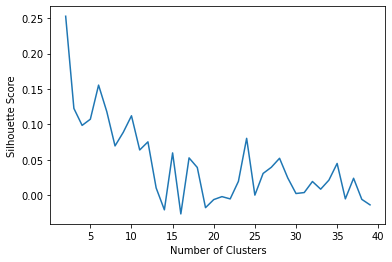

In [14]:
import matplotlib.pyplot as plt 
plt.plot(range(2, num_clusters), sil_scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [15]:
opt_sil_score = max(sil_scores[5:20])
sil_scores.index(opt_sil_score)
opt_num_cluster = range(2, num_clusters)[sil_scores.index(opt_sil_score)]
print('The optimal number of clusters is %s' %opt_num_cluster)

The optimal number of clusters is 7


In [16]:
km = KMeans(n_clusters=opt_num_cluster)
km.fit(X)
doc_clusters = km.labels_.tolist()

df['cluster_mean'] = doc_clusters
df[df['cluster_mean']==1]['opinion_text']


20     Justice Stevens delivered the opinion of the C...
21     Justice Ginsburg delivered the opinion of the ...
22     Justice Breyer delivered the opinion of the Co...
23     Justice Scalia announced the judgment of the C...
27     Justice Thomas delivered the opinion of the Co...
                             ...                        
702    JUSTICE GINSBURG delivered the opinion of the ...
703    JUSTICE SOUTER delivered the opinion of the Co...
755    JUSTICE SOUTER delivered the opinion of the Co...
787    JUSTICE KENNEDY delivered the opinion of the C...
803    JUSTICE O'CONNOR delivered the opinion of the ...
Name: opinion_text, Length: 76, dtype: object

## K-Medoids

In [19]:
#!pip install scikit-learn-extra
from sklearn_extra.cluster import KMedoids

kmed = KMedoids(n_clusters=opt_num_cluster)
kmed.fit(X)
doc_clusters = kmed.labels_.tolist()

df['cluster_med'] = doc_clusters
df[df['cluster_med']==1]['opinion_text']

11     Justice Ginsburg delivered the opinion of the ...
19     Justice Kennedy delivered the opinion of the C...
25     Justice Thomas delivered the opinion of the Co...
26     Justice Scalia delivered the opinion of the Co...
28     Justice Ginsburg delivered the opinion of the ...
                             ...                        
800    JUSTICE BREYER delivered the opinion of the Co...
801    JUSTICE GINSBURG delivered the opinion of the ...
805    CHIEF JUSTICE REHNQUIST delivered the opinion ...
808    JUSTICE SCALIA delivered the opinion of the Co...
817    JUSTICE SCALIA delivered the opinion of the Co...
Name: opinion_text, Length: 144, dtype: object

## DBSCAN

In [20]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.95, min_samples=5)
dbscan.fit(X_tfidf)
db_clusters = dbscan.labels_

df['cluster_db'] = db_clusters
df[df['cluster_db']==1]['opinion_text']

25     Justice Thomas delivered the opinion of the Co...
36     Justice Alito delivered the opinion of the Cou...
45     Justice Scalia delivered the opinion of the Co...
67     JUSTICE SCALIA delivered the opinion of the Co...
78     Justice Breyer announced the judgment of the C...
250    JUSTICE SCALIA delivered the opinion of the Co...
383    Justice Ginsburg delivered the opinion of the ...
392    Justice Souter delivered the opinion of the Co...
461    Justice Ginsburg delivered the opinion of the ...
468    Justice Thomas delivered the opinion of the Co...
484    Justice Scalia delivered the opinion of the Co...
580    JUSTICE BREYER delivered the opinion of the Co...
616    JUSTICE SOUTER delivered the opinion of the Co...
623    CHIEF JUSTICE REHNQUIST delivered the opinion ...
652    JUSTICE STEVENS delivered the opinion of the C...
764    JUSTICE GINSBURG delivered the opinion of the ...
Name: opinion_text, dtype: object

### Hierarchical DBSCAN

Automatically chooses epsilon, performing DBSCAN over various epsilon values e returns the result that gives the best stability over epsilon. For reference see [here](https://github.com/scikit-learn-contrib/hdbscan/).

In [22]:
#!pip install hdbscan

from hdbscan import HDBSCAN

hdbscan = HDBSCAN(min_cluster_size=5)
hdbscan.fit(X_tfidf)
hdb_clusters = hdbscan.labels_

df['cluster_hdb'] = hdb_clusters
df[df['cluster_hdb']==1]['opinion_text']

96     Justice Ginsburg delivered the opinion of the ...
199    Justice Stevens delivered the opinion of the C...
212    Justice Scalia delivered the opinion of the Co...
326    Justice Souter delivered the opinion of the Co...
327    Justice Stevens delivered the opinion of the C...
364    Justice Alito delivered the opinion of the Cou...
385    Justice Scalia delivered the opinion of the Co...
458    Justice Stevens delivered the opinion of the C...
469    Justice Scalia delivered the opinion of the Co...
505    Justice Kennedy delivered the opinion of the C...
540    JUSTICE STEVENS delivered the opinion of the C...
596    JUSTICE BREYER delivered the opinion of the Co...
615    JUSTICE KENNEDY delivered the opinion of the C...
617    JUSTICE O'CONNOR delivered the opinion of the ...
676    JUSTICE O'CONNOR delivered the opinion of the ...
808    JUSTICE SCALIA delivered the opinion of the Co...
Name: opinion_text, dtype: object

## Hierarchical Clustering

In [23]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=opt_num_cluster, affinity='euclidean', linkage='ward')
cluster.fit_predict(X)

clusters = dbscan.labels_

df['cluster_hie'] = clusters
df[df['cluster_hie']==1]['opinion_text']


25     Justice Thomas delivered the opinion of the Co...
36     Justice Alito delivered the opinion of the Cou...
45     Justice Scalia delivered the opinion of the Co...
67     JUSTICE SCALIA delivered the opinion of the Co...
78     Justice Breyer announced the judgment of the C...
250    JUSTICE SCALIA delivered the opinion of the Co...
383    Justice Ginsburg delivered the opinion of the ...
392    Justice Souter delivered the opinion of the Co...
461    Justice Ginsburg delivered the opinion of the ...
468    Justice Thomas delivered the opinion of the Co...
484    Justice Scalia delivered the opinion of the Co...
580    JUSTICE BREYER delivered the opinion of the Co...
616    JUSTICE SOUTER delivered the opinion of the Co...
623    CHIEF JUSTICE REHNQUIST delivered the opinion ...
652    JUSTICE STEVENS delivered the opinion of the C...
764    JUSTICE GINSBURG delivered the opinion of the ...
Name: opinion_text, dtype: object

## Principal Component Analysis

In [24]:
#%% Principal Components
from sklearn.decomposition import PCA
pca = PCA(n_components=3,svd_solver='randomized')
Xpca = pca.fit_transform(X)
pca.explained_variance_ratio_

array([0.06008335, 0.03858286, 0.03146097])

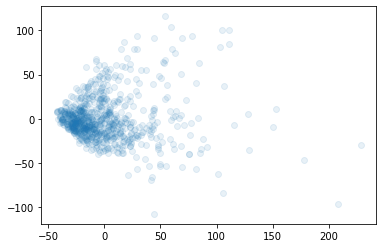

In [25]:
#%% PCA Viz
plt.scatter(Xpca[:,0],Xpca[:,1], alpha=.1)
plt.show()

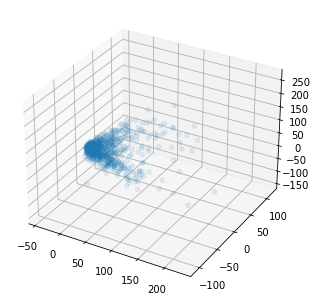

In [26]:
#%% PCA 3D Viz
from mpl_toolkits.mplot3d import Axes3D
Axes3D(plt.figure()).scatter(Xpca[:,0],Xpca[:,1], Xpca[:,2], alpha=.1)
plt.show()

In [27]:
#%% make components to explain 95% of variance
pca = PCA(n_components=.95)
X95 = pca.fit_transform(X)
pca.n_components_

304

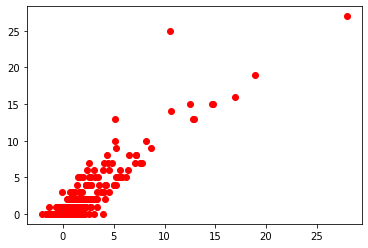

In [28]:
#%% PCA Inverse Transform
Xrestore = pca.inverse_transform(X95)
plt.plot(Xrestore[0],X[0],'ro')

In [29]:
#%% Incremental PCA
X_mm = np.memmap('X.pkl',shape=(32567, 525))

from sklearn.decomposition import IncrementalPCA
inc_pca = IncrementalPCA(n_components=100, batch_size=1000)
inc_pca.fit(X_mm)

IncrementalPCA(batch_size=1000, n_components=100)

In [30]:
#%% PC Regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
Y = df['log_cite_count']
lin_reg = LinearRegression()
scores = cross_val_score(lin_reg,
                         X95[:,:10],
                         Y) 
scores.mean()

0.19279759436150065

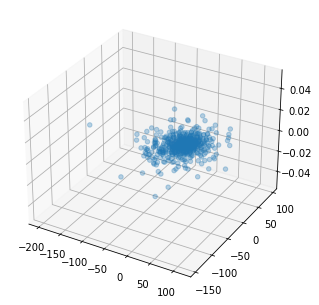

In [31]:
#%% MDS, Isomap, and T-SNE
from sklearn.manifold import MDS, Isomap, TSNE
mds = MDS(n_components=2)
Xmds = mds.fit_transform(X[:500,:200])
Axes3D(plt.figure()).scatter(Xmds[:,0],Xmds[:,1], alpha=.3)

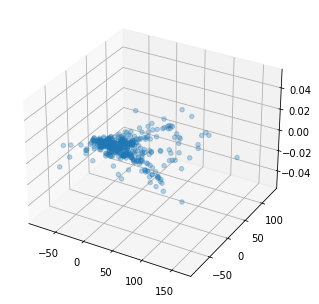

In [32]:
#%% Isomap
iso = Isomap(n_components=2)
Xiso = iso.fit_transform(X[:500,:200])
Axes3D(plt.figure()).scatter(Xiso[:,0],Xiso[:,1], alpha=.3)

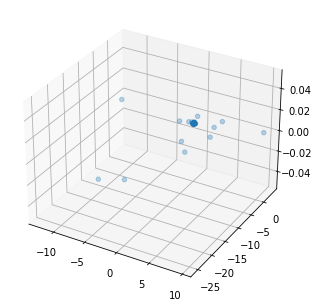

In [33]:
#%% t-SNE
tsne = TSNE(n_components=2, n_iter=250)
Xtsne = tsne.fit_transform(X[:500,:200])
Axes3D(plt.figure()).scatter(Xtsne[:,0],Xtsne[:,1], alpha=.3)

# Latent Dirichlet Allocation

For further reference see the material from topic [modeling with gensim](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/).

In [34]:
# clean document
from gensim.utils import simple_preprocess
import spacy
from spacy.tokenizer import Tokenizer
from tqdm import tqdm as tq
nlp = spacy.load('en_core_web_sm')
# this is faster and we don't need the whole grammatical parse analysis

def tokenize(x, nlp):
    # lemmatize and lowercase without stopwords, punctuation and numbers
    return [w.lemma_.lower() for w in nlp(x) if not w.is_stop and not w.is_punct and not w.is_digit and len(w) > 2]

# split into paragraphs
doc_clean = []
for doc in tq(df['opinion_text'][:100]):
    # split by paragraph
    for paragraph in doc.split("\n\n"):
        doc_clean.append(tokenize(paragraph, nlp))
print (doc_clean[:2])


# randomize document order
from random import shuffle
shuffle(doc_clean)

# creating the term dictionary
from gensim import corpora
dictionary = corpora.Dictionary(doc_clean)
# filter extremes, drop all words appearing in less than 10 paragraphs and all words appearing in at least every third paragraph
dictionary.filter_extremes(no_below=10, no_above=0.33, keep_n=1000)
print (len(dictionary))


# creating the document-term matrix
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

# train LDA with 10 topics and print
from gensim.models.ldamodel import LdaModel
lda = LdaModel(doc_term_matrix, num_topics=10, 
               id2word = dictionary, passes=3)
lda.show_topics(formatted=True)

100%|██████████| 100/100 [02:19<00:00,  1.39s/it]


[['justice', 'ginsburg', 'deliver', 'opinion', 'court'], ['motion', 'federal', 'prisoner', 'postconviction', 'relief', 'u.s.c.', 'subject', 'year', 'time', 'limitation', 'generally', 'run', 'date', 'judgment', 'conviction', 'final', 'p6(1', 'case', 'concern', 'starting', 'date', 'year', 'limitation', 'present', 'narrow', 'recur', 'question', 'court', 'appeal', 'divide', 'defendant', 'federal', 'prosecution', 'take', 'unsuccessful', 'direct', 'appeal', 'judgment', 'conviction', 'petition', 'writ', 'certiorari', 'court', 'judgment', 'final', 'postconviction', 'relief', 'purpose', 'appellate', 'court', 'issue', 'mandate', 'affirm', 'conviction', 'instead', 'date', 'ordinarily', 'day', 'later', 'time', 'file', 'petition', 'certiorari', 'expire']]


1000


[(0,
  '0.022*"state" + 0.021*"u.s." + 0.020*"case" + 0.019*"decision" + 0.018*"right" + 0.018*"property" + 0.016*"adec" + 0.015*"clause" + 0.013*"taking" + 0.012*"judicial"'),
 (1,
  '0.053*"u.s." + 0.032*"state" + 0.025*"law" + 0.022*"states" + 0.021*"united" + 0.015*"congress" + 0.013*"statute" + 0.012*"act" + 0.012*"federal" + 0.011*"foreign"'),
 (2,
  '0.026*"trial" + 0.021*"state" + 0.020*"jury" + 0.019*"evidence" + 0.017*"defendant" + 0.016*"id." + 0.015*"counsel" + 0.014*"case" + 0.012*"u.s." + 0.012*"statement"'),
 (3,
  '0.026*"claim" + 0.022*"petitioner" + 0.016*"motion" + 0.015*"rule" + 0.015*"district" + 0.014*"respondent" + 0.014*"state" + 0.012*"file" + 0.012*"case" + 0.012*"federal"'),
 (4,
  '0.025*"agreement" + 0.021*"party" + 0.017*"arbitration" + 0.015*"act" + 0.013*"insurance" + 0.013*"contract" + 0.012*"provision" + 0.012*"term" + 0.010*"dispute" + 0.010*"u.s.c."'),
 (5,
  '0.019*"copyright" + 0.015*"law" + 0.014*"states" + 0.014*"board" + 0.014*"brief" + 0.013*"g

In [35]:
# to get the topic proportions for a document, use
# the corresponding row from the document-term matrix.
lda[doc_term_matrix[1]]

[(1, 0.517137), (5, 0.40367875), (9, 0.06903553)]

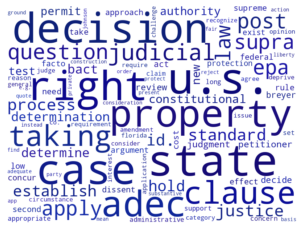

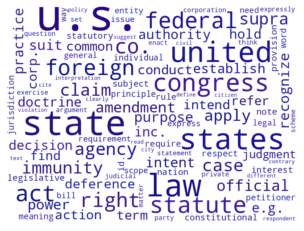

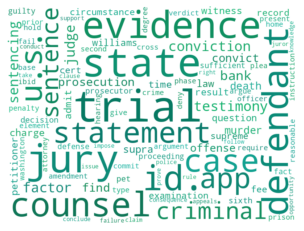

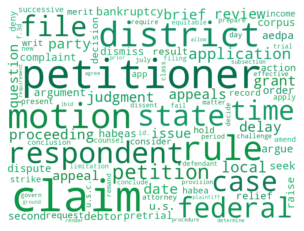

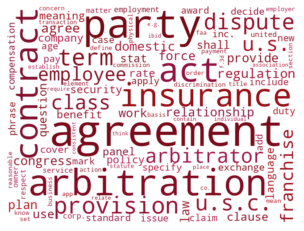

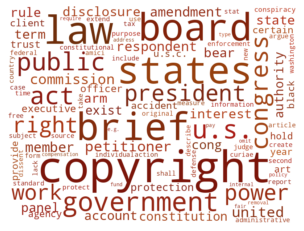

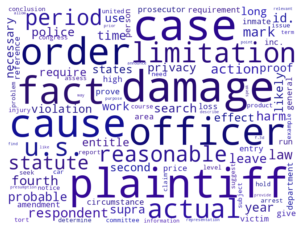

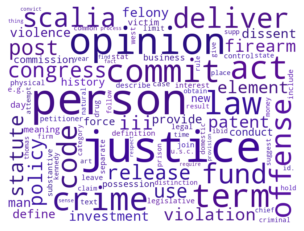

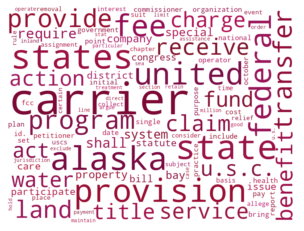

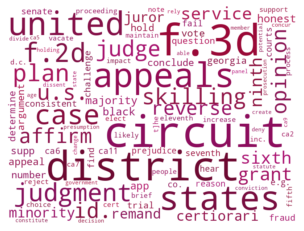

In [36]:
###
# LDA Word Clouds
###

from numpy.random import randint
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# make directory if not exists
from os import mkdir
try:
    mkdir('lda')
except:
    pass

# make word clouds for the topics
for i,weights in lda.show_topics(num_topics=-1,
                                 num_words=100,
                                 formatted=False):
    
    #logweights = [w[0], np.log(w[1]) for w in weights]
    maincol = randint(0,360)
    def colorfunc(word=None, font_size=None, 
                  position=None, orientation=None, 
                  font_path=None, random_state=None):   
        color = randint(maincol-10, maincol+10)
        if color < 0:
            color = 360 + color
        return "hsl(%d, %d%%, %d%%)" % (color,randint(65, 75)+font_size / 7, randint(35, 45)-font_size / 10)   

    
    wordcloud = WordCloud(background_color="white", 
                          ranks_only=False, 
                          max_font_size=120,
                          color_func=colorfunc,
                          height=600,width=800).generate_from_frequencies(dict(weights))

    plt.clf()
    plt.imshow(wordcloud,interpolation="bilinear")
    plt.axis("off")
    plt.show()


In [38]:
# pyLDAvis, for more details, refer to https://github.com/bmabey/pyLDAvis
# !pip install pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda, doc_term_matrix, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.023344 -0.039728       1        1  15.499015
3      0.108080 -0.009978       2        1  14.224218
2      0.089887  0.163587       3        1  11.319633
4     -0.127549 -0.073068       4        1  10.230702
5     -0.063313 -0.036292       5        1   9.186418
6     -0.034318  0.074962       6        1   8.882080
0      0.043944  0.039075       7        1   8.238315
8     -0.071373 -0.116036       8        1   7.991155
9      0.212502 -0.097795       9        1   7.546166
7     -0.134516  0.095273      10        1   6.882299, topic_info=         Term         Freq        Total Category  logprob  loglift
12    circuit   657.000000   657.000000  Default  30.0000  30.0000
116  district   971.000000   971.000000  Default  29.0000  29.0000
23       f.3d   809.000000   809.000000  Default  28.0000  28.0000
45     states  1496.000000  1496.000000  Default  27.0000  27.0000
464   carrier   398.000000   398.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
16     define    68.394976   247.387623  Topic10  -5.1233   1.3906
14   congress    99.567321   909.232965  Topic10  -4.7478   0.4645
713   dissent    74.950215   358.866359  Topic10  -5.0318   1.1101
46    statute    90.520365   826.099622  Topic10  -4.8430   0.4651
238   provide    70.190178   620.776072  Topic10  -5.0974   0.4965

[544 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
385       1  0.156081  absence
385       3  0.085135  absence
385       4  0.042567  absence
385       5  0.014189  absence
385       6  0.539187  absence
...     ...       ...      ...
78        6  0.287445     year
78        7  0.006459     year
78        8  0.071054     year
78        9  0.006459     year
78       10  0.138878     year

[2754 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 3, 5, 6, 7, 1, 9, 10, 8])

Using Mallet to calculate coherence scores for different number of topics to automatically determine the best number of topics


In [40]:
# !wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
# !unzip mallet-2.0.8.zip

In [42]:
# you need gensim version <= 3.8.3 for this to work
# !pip install gensim==3.8.3
import gensim
from gensim.corpora import Dictionary
from gensim.models.wrappers import LdaMallet
from gensim.models.coherencemodel import CoherenceModel
warnings.filterwarnings("ignore")

mallet_path = 'mallet-2.0.8/bin/mallet'
scores = []
for num_topics in range(2, 20, 2):
    print (num_topics)
    lda = LdaMallet(mallet_path, doc_term_matrix, num_topics=num_topics, id2word=dictionary)
    coherence = CoherenceModel(model=lda, texts=doc_clean, corpus=doc_term_matrix, dictionary=dictionary, coherence='c_v')
    scores.append((num_topics, coherence.get_coherence()))
pd.DataFrame(scores, columns=["Number of Topics", "Coherence Scores"])



2
4
6
8
10
12
14
16
18


,Number of Topics,Coherence Scores
0,2,0.344446
1,4,0.400090
2,6,0.413696
3,8,0.407373
4,10,0.412365
5,12,0.427318
6,14,0.424717
7,16,0.429450
8,18,0.431933


## Singular Value Decomposition (SVD)

For further reference for this and the following section see [here](https://github.com/fastai/course-nlp/blob/219d0c217bd83339e21471d31cd787e86d6ec0a0/2-svd-nmf-topic-modeling.ipynb).

In [43]:
upload_4 = files.upload()

Saving vec-3grams-1.pkl to vec-3grams-1.pkl


In [46]:
from scipy import linalg

X = pd.read_pickle('X.pkl').todense()
vec = pd.read_pickle('vec-3grams-1.pkl')
vocab = np.array(vec.get_feature_names_out())
vocab[400:500]


array(['department', 'described', 'designed', 'despite', 'detention',
       'determination', 'determine', 'determined', 'determining',
       'different', 'difficult', 'direct', 'directly', 'discharge',
       'discretion', 'discrimination', 'dismissed', 'dispute', 'dissent',
       'dissenting', 'distinction', 'district', 'district court',
       'districts', 'doctrine', 'domestic', 'doubt', 'drug', 'drugs',
       'duty', 'earlier', 'ed supp', 'education', 'effect', 'effective',
       'election', 'element', 'elements', 'emphasis', 'emphasis added',
       'employee', 'employees', 'employer', 'employment', 'enacted',
       'end', 'enforce', 'enforcement', 'entered', 'entitled', 'epa',
       'equal', 'equitable', 'erisa', 'error', 'establish', 'established',
       'et', 'et seq', 'event', 'evidence', 'ex', 'example', 'exception',
       'executive', 'exercise', 'existing', 'explained', 'express',
       'expressly', 'extent', 'fact', 'factor', 'factors', 'facts',
       'factual',

In [47]:
U, s, Vh = linalg.svd(X, full_matrices=False)
print(U.shape, s.shape, Vh.shape)

(768, 768) (768,) (768, 1000)


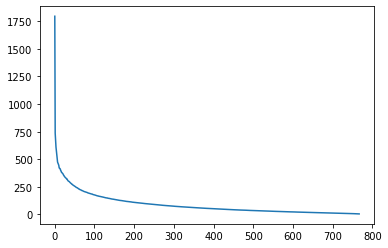

In [48]:
plt.plot(s)

In [49]:
num_top_words=8

def show_topics(a):
    top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_top_words-1:-1]]
    topic_words = ([top_words(t) for t in a])
    return [' '.join(t) for t in topic_words]

show_topics(Vh[:10])

['924 debtor securities trust fourth amendment equitable summary judgment waiver',
 'state trial evidence jury counsel defendant death sentence',
 'state state law commerce pre property state court immunity districts',
 'district district court jurisdiction claims claim rule courts habeas',
 'district right amendment school rights minority speech districts',
 'right military jurisdiction habeas war courts rights amendment',
 'rule right tax claim action party arbitration property',
 'school government public tax religious schools program commission',
 'commission tax rate party military judge war plan',
 'counsel rate service evidence right cost act epa']

## Non-negative Matrix Factorization (NMF) 

In [54]:
from sklearn import decomposition

clf = decomposition.NMF(n_components=10, random_state=1)
X = np.array(X)
W1 = clf.fit_transform(X)
H1 = clf.components_

show_topics(H1)

['state new state court state law courts laws clause authority',
 'evidence counsel trial defendant petitioner rule jury app',
 'death sentence penalty jury sentencing death penalty crime offense',
 'district district court minority districts plan voting school majority',
 'act congress statute government agency use authority regulations',
 'right amendment rights bear second government clause constitutional',
 'military war habeas commission jurisdiction government courts cases',
 'action claims claim jurisdiction rule district parties district court',
 'rate service cost commission rates elements local market',
 'tax judge rule trial special income report property']

## Author Topic Model

In [55]:
from gensim.models import AuthorTopicModel
from gensim.test.utils import temporary_file

df = df.reset_index()
df['id'] = df.index
author2doc = df[:100][['authorship','id']]
author2doc = author2doc.groupby('authorship').apply(lambda x: list(x['id'])).to_dict()
author2doc

{'ALITO': [14, 29, 30, 33, 39, 43],
 'BREYER': [6, 10, 15, 19, 26, 36, 54, 73, 74, 80, 81, 95],
 'GINSBURG': [0, 7, 9, 11, 18, 25, 27, 52, 68, 84, 86, 90, 96, 97],
 'KENNEDY': [3, 4, 16, 21, 34, 40, 42, 48, 62, 64, 65, 76, 85, 87],
 "O'CONNOR": [2, 49, 59, 66, 75, 83, 88],
 'REHNQUIST': [55, 56, 70, 79, 94],
 'ROBERTS': [12, 35, 44],
 'SCALIA': [20, 23, 28, 37, 41, 45, 51, 61, 63, 82, 98],
 'SOUTER': [5, 47, 53, 67, 72, 78, 91, 92],
 'STEVENS': [1, 17, 31, 32, 38, 46, 57, 60, 71, 93],
 'THOMAS': [8, 13, 22, 24, 50, 58, 69, 77, 89, 99]}

In [56]:
model = AuthorTopicModel(
        doc_term_matrix, author2doc=author2doc, id2word=dictionary, num_topics=10)

# For each author list topic distribution
author_vecs = [model.get_author_topics(author) for author in model.id2author.values()]
author_vecs[:2]

[[(7, 0.996355104267287)], [(2, 0.9953354818018735)]]